In [1]:
import contextlib
import glob
import io
import json
import os
import random
import time

from fvcore.common.file_io import PathManager
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import torch 

import detectron2
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.structures import BoxMode

# local .json file with local path info
geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(
    os.path.join(local_paths["general_dection_path"],
                 "detectron2_classes")
)
from DetectionDatasetMapper import DetectionDatasetMapper
from PrecisionRecallEvaluator import PrecisionRecallEvaluator
from GroundtruthVisualizer import GroundtruthVisualizer

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
base_folder = local_paths['base_ungulates']

In [4]:
images_folder = os.path.dirname(base_folder)

In [5]:

# model_name = 'LRscheduler-cropped-half-res_maxiter-28600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8'
# model_name = 'LRscheduler-cropped-full-aug-half-res_maxiter-42900_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8'
# model_name = 'LRscheduler-cropped-flip-aug-half-res_maxiter-42900_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8'
model_name = "full-resolution-model_maxiter-50267_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"
yaml_file = os.path.join("output", model_name, 'config.yaml')
print(yaml_file)

output/full-resolution-model_maxiter-50267_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/config.yaml


In [6]:
cfg = get_cfg()
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(cfg.OUTPUT_DIR, "best-model-config-iter-*.pth"))
)[-1]
print(weights_path)
cfg.MODEL.WEIGHTS = os.path.join(weights_path)

./output/full-resolution-model_maxiter-50267_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/best-model-config-iter-50099-loss-0.4353338385806898.pth


In [7]:
print(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 ????
print(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

0.05
5


In [8]:
cfg.INPUT.AUG_ON_TEST

False

In [9]:
train_json = os.path.join(base_folder, 'train.json') 
val_json = os.path.join(base_folder, 'val.json')

register_coco_instances("train", {}, train_json, images_folder)
register_coco_instances("val", {}, val_json, images_folder)

In [10]:
train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")

In [11]:
train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

['zebra', 'gazelle', 'wbuck', 'buffalo', 'other']

In [12]:
num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
print(f"{num_train_images} training images \n"
      + f"{num_val_images} validation images")

1340 training images 
286 validation images


In [13]:
dataset_name = "val"
mapper = DetectionDatasetMapper(cfg, is_train=False, calc_val_loss=False)
# loader = build_detection_train_loader(cfg, mapper=mapper, )
loader = build_detection_test_loader(cfg,
                                     dataset_name,
                                     mapper
                                    )

/home/golden/detectron2aug16/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


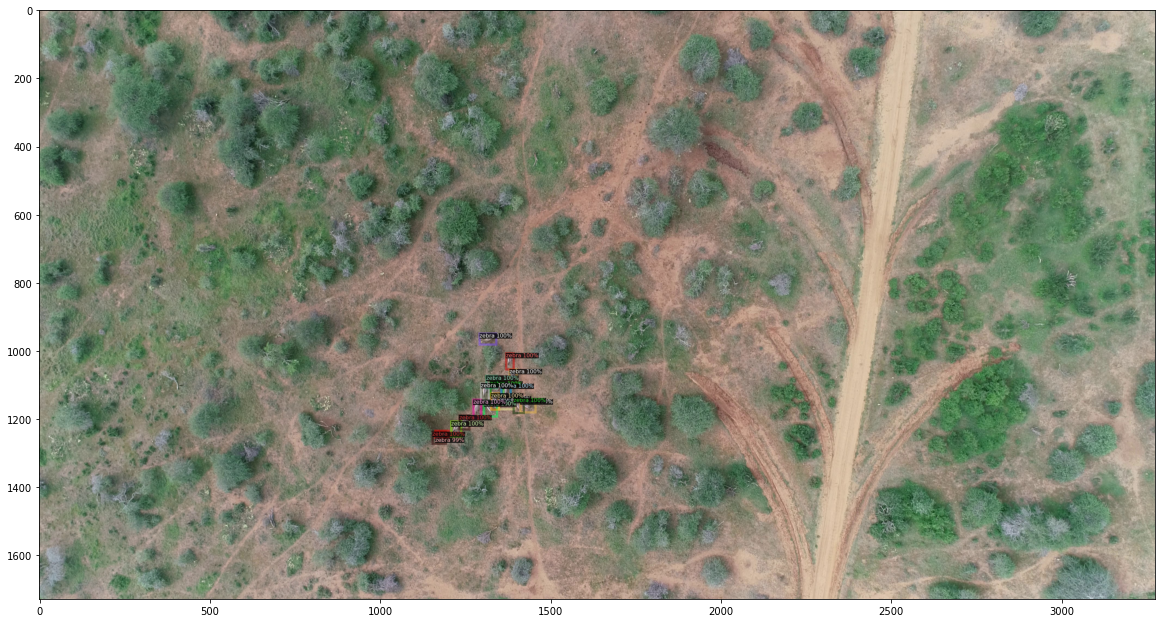

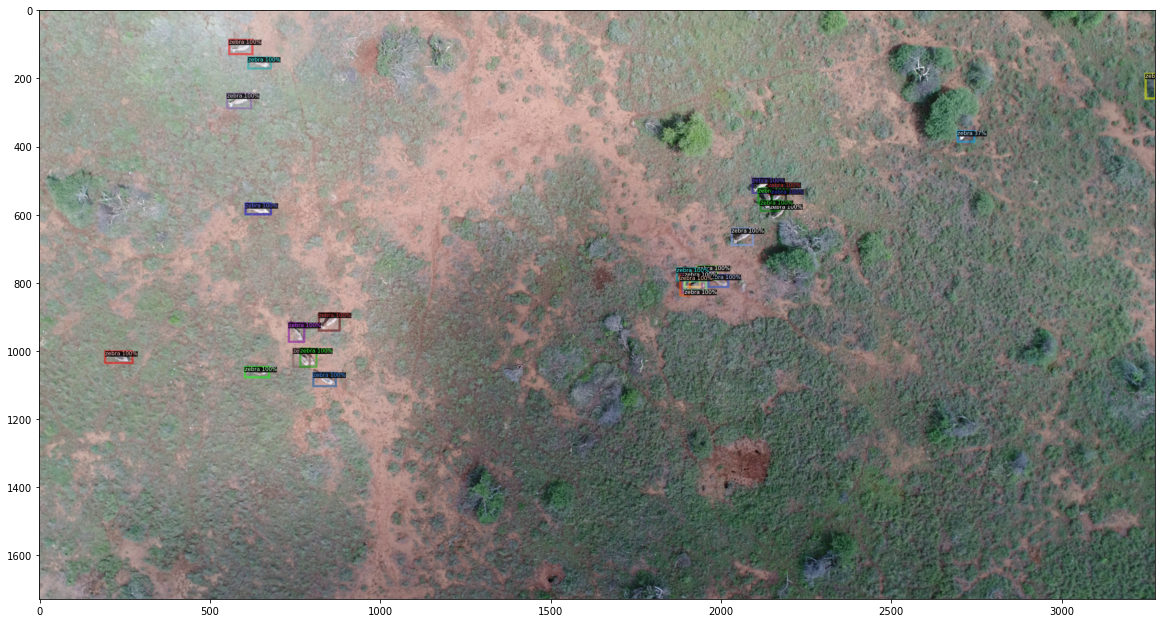

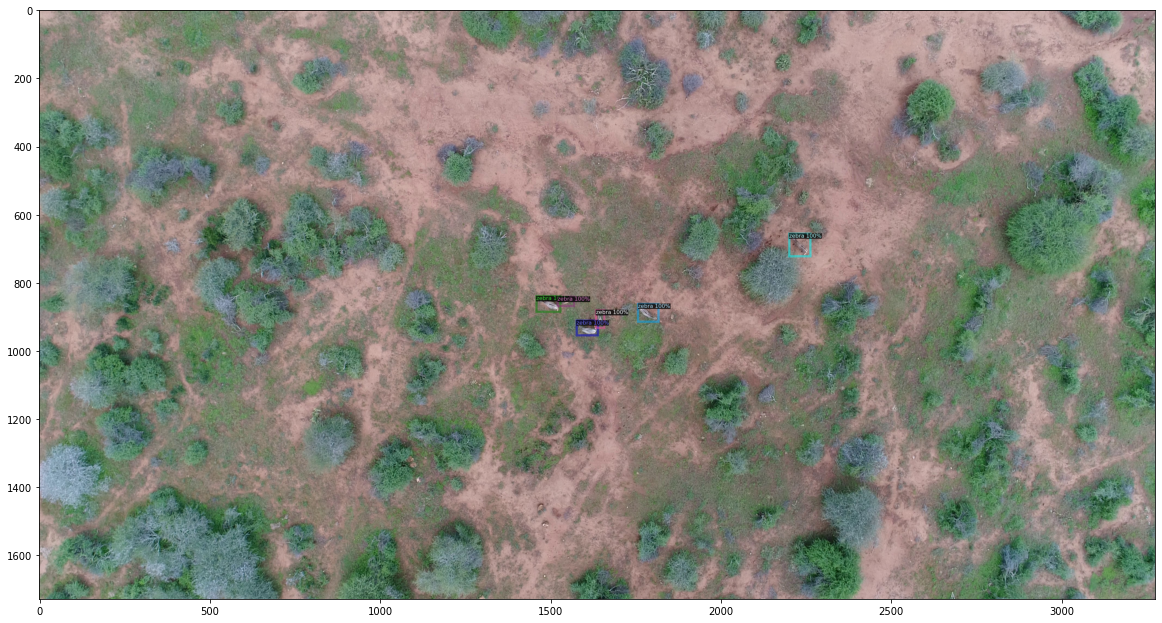

In [14]:
cfg.DATASETS.TEST = (dataset_name, )
predictor = DefaultPredictor(cfg)

for d in random.sample(val_dicts, 3):
# for d in train_dicts:
#     im = cv2.imread(d["file_name"])
    im = utils.read_image(
        d["file_name"], format=cfg.INPUT.FORMAT
    )
    outputs = predictor(im)
    v = GroundtruthVisualizer(im[:, :, ::],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])

In [15]:
dataset_metadata = MetadataCatalog.get(dataset_name)
json_file = PathManager.get_local_path(dataset_metadata.json_file)
with contextlib.redirect_stdout(io.StringIO()):
    coco_api = COCO(json_file)

In [16]:
coco_api.createIndex()

creating index...
index created!


In [17]:

# Check training

evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False)
# evaluator = COCOEvaluator(dataset_name, cfg, distributed=False)
evaluator.reset()

show_ims = False
show_gts = False

cfg.DATASETS.TEST = (dataset_name, )
# predictor = DefaultPredictor(cfg)

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

pred_dicts = val_dicts
num_frames = len(pred_dicts)
# num_frames = 10



all_outputs = []

t = time.time()
with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')

        outputs = model(batch)
        

        all_outputs.extend(outputs)
    
        evaluator.process(batch, outputs)
        if show_ims:   
            for ind, output in enumerate(outputs):
                im = (
                    np.transpose(batch[0]['image'].numpy(), (1, 2, 0))
                ).astype(int)
                
                im_id = batch[ind]['image_id']

                gts=coco_api.loadAnns(coco_api.getAnnIds(imgIds=[im_id]))
                anno_dict = {}
                for gt in gts:
                    gt['bbox_mode'] = BoxMode.XYWH_ABS
                anno_dict['annotations'] = gts
                
                scale = 0.8
                if show_gts:
                    v = GroundTruthVisualizer(im,
                               metadata=train_metadata,
                               scale=1.0,
                    )
                    v_gt = v.draw_dataset_dict(anno_dict)
                    im = v_gt.get_image()
                    plt.figure(figsize=(20, 20))
                    plt.imshow(v_gt.get_image()[:, :, ::-1])
                v = Visualizer(im,
                               metadata=train_metadata,
                               scale=scale,
                )
                v_im = v.draw_instance_predictions(output["instances"].to("cpu"))
                
                plt.figure(figsize=(20, 20))
                plt.imshow(v_im.get_image()[:, :, ::-1])
                
                
        if batch_num >= 1000:
            print(f'batch {batch_num}')
            break
total_time = time.time() - t
print(f"fps: {num_frames/total_time}, total_time {total_time}, num_frames {num_frames}")

coco_result = evaluator.evaluate()

processed batch 0
processed batch 50
processed batch 100
processed batch 150
processed batch 200
processed batch 250
fps: 2.3983246540774736, total_time 119.24991035461426, num_frames 286
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.10 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [ ]:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000

In [18]:
coco_result['bbox']['res']

{'AP': 68.86153706671936,
 'AP50': 97.63366421518307,
 'AP75': 84.11368665500461,
 'APs': 43.38263853765636,
 'APm': 69.22729823152125,
 'APl': 48.02374872216686,
 'AP-zebra': 70.28191702484742,
 'AP-gazelle': 63.81843139320688,
 'AP-wbuck': 79.9079202947533,
 'AP-buffalo': 64.31524569691919,
 'AP-other': 65.9841709238701}

No aug

{'AP': 68.19046325241783,
 'AP50': 97.22629604570542,
 'AP75': 81.93823731253634,
 'APs': 66.89511946662925,
 'APm': 62.082856676160816,
 'APl': nan,
 'AP-zebra': 67.41322050890676,
 'AP-gazelle': 62.73871998395249,
 'AP-wbuck': 78.8799051024195,
 'AP-buffalo': 67.42359859484478,
 'AP-other': 64.4968720719657}
 
 All aug
 
 {'AP': 63.03237560962104,
 'AP50': 96.71677249750246,
 'AP75': 74.1352097193948,
 'APs': 61.69669320369372,
 'APm': 62.95608965318903,
 'APl': nan,
 'AP-zebra': 66.23108001342014,
 'AP-gazelle': 55.30440420147143,
 'AP-wbuck': 75.23421302692321,
 'AP-buffalo': 62.63707086594894,
 'AP-other': 55.755109940341505}
 
 Flip aug
 
 {'AP': 63.90007248864249,
 'AP50': 96.77936851861946,
 'AP75': 76.29476948356232,
 'APs': 62.67607516714499,
 'APm': 62.009385438724486,
 'APl': nan,
 'AP-zebra': 66.69324436700366,
 'AP-gazelle': 56.10109473752952,
 'AP-wbuck': 75.49778413000618,
 'AP-buffalo': 63.659811711022996,
 'AP-other': 57.548427497650124}

In [19]:
precisions = coco_result['bbox']['precision']
precision = precisions[:, :, 0, 0, -1]
precision = precision[precision > -1]
ap = np.mean(precision) if precision.size else float("nan")
print(ap)

0.7028191702484742


In [20]:
print(precision.shape)
print(coco_result['bbox']['params'].useCats)

(1010,)
1


0.7028191702484742


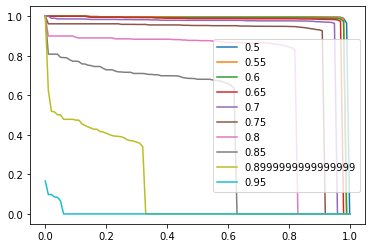

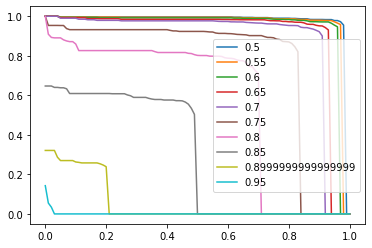

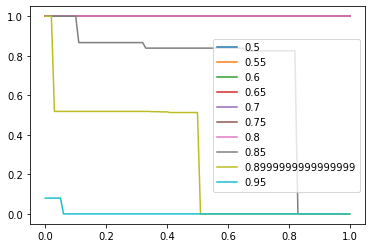

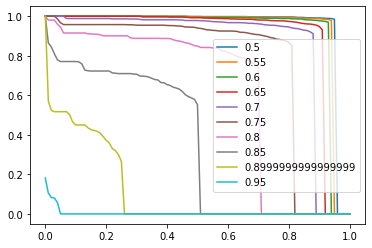

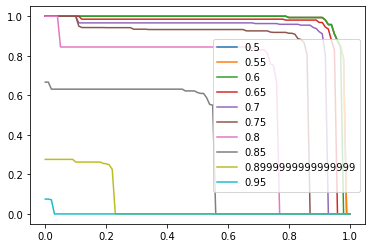

In [21]:
params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']
print(np.mean(precision[:, :, 0, 0, 2]))
for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, precision[iou_ind, :, obj_class, 0, 2], label=iou_thrsh)
    plt.legend()

0.7028191702484742


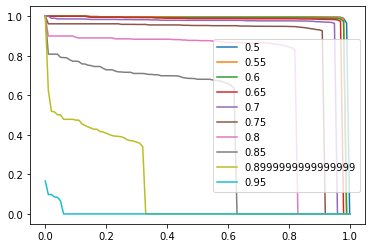

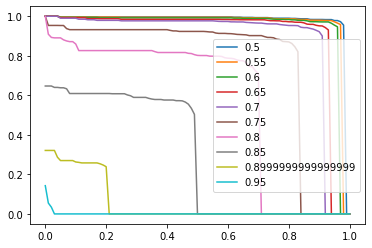

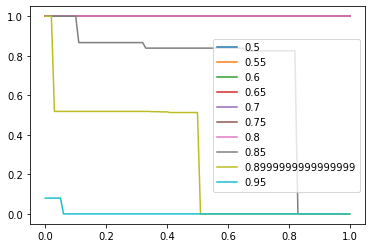

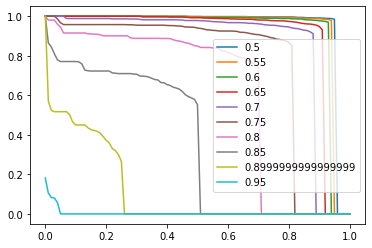

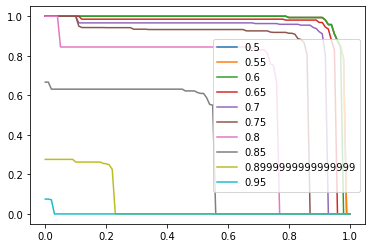

In [22]:
params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']
print(np.mean(precision[:, :, 0, 0, 2]))
for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, precision[iou_ind, :, obj_class, 0, 2], label=iou_thrsh)
    plt.legend()

In [23]:
# coco_result['bbox']['coco_eval']['scores']

In [46]:
out_instances = output["instances"].to("cpu")
out_instances.pred_boxes

NameError: name 'output' is not defined

In [154]:
gt_bbox = [a['bbox'] for a in coco_api.dataset['annotations'] if a['image_id'] == im_id]
dt_bbox = [a['bbox'] for a in coco_dt.dataset['annotations']]
annos = [a['bbox'] for a in anno_dict['annotations']]

In [155]:
print(np.stack(gt_bbox))
print(out_instances.pred_boxes)
# print(prediction["instances"])
# print(np.stack(dt_bbox))

[[1328.   542.    40.    16. ]
 [1450.5  436.5   38.    20.5]
 [1303.   526.5   37.    23.5]
 [ 996.5  330.5   17.    34. ]
 [1397.   576.5   37.5   24.5]
 [ 978.5  476.5   30.    29.5]
 [ 610.   408.    40.5   23. ]
 [ 609.5  478.5   37.    18.5]
 [1420.5  515.    26.    32. ]
 [ 380.5  429.5   36.5   20. ]
 [1767.   255.    18.    35.5]
 [1347.5  563.5   35.5   22. ]
 [ 921.5  377.5   31.    25. ]
 [1526.   485.5   35.    20.5]
 [1442.   443.    19.5   35.5]
 [ 950.5  402.5   37.    16.5]
 [1765.5  296.    25.5   34.5]
 [1761.5  240.5   18.    33.5]
 [1795.   327.5   34.5   24. ]
 [1765.   158.    19.5   42. ]
 [1800.5  365.5   35.5   25. ]
 [1750.   127.    28.5   35. ]
 [ 972.   449.5   30.    23. ]]
Boxes(tensor([[1304.9272,  524.8882, 1341.0674,  550.8210],
        [ 979.5905,  478.3118, 1010.7137,  506.8691],
        [1441.3162,  442.7038, 1461.2266,  476.2024],
        [1801.6318,  365.9084, 1835.6147,  390.8714],
        [ 611.0220,  477.8048,  647.6956,  496.3259],
        [1

1

In [64]:
# gts=coco_api.loadAnns(coco_api.getAnnIds(imgIds=[im_id]))
# anno_dict = {}
# for gt in gts:
#     gt['bbox_mode'] = '<BoxMode.XYWH_ABS: 1>'
# anno_dict['annotations'] = gts


In [46]:
# outputs

In [106]:
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from pycocotools.cocoeval import COCOeval

In [37]:
# gt_bboxes = np.stack([gt['bbox'] for gt in gts])
# pred_bboxes = np.stack([pred['bbox'] for pred in predictions[0]['instances']])

# print(gt_bboxes)
# print(pred_bboxes)

In [161]:
im_id

1

In [157]:
# predictions = []

# for input, output in zip(batch, outputs):
#     im_id = input['image_id']
#     print(im_id)
#     prediction = {"image_id": input["image_id"]}
#     if "instances" in output:
#         output["instances"].pred_classes += 1 
#         instances = output["instances"].to(torch.device("cpu"))
#         prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
#     predictions.append(prediction)
# coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
# coco_dt = coco_api.loadRes(coco_results)

1
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [162]:
# cocoEval._gts

In [132]:
len(coco_dt.imgToAnns[7])

27

In [163]:
# running evaluation
cocoEval = COCOeval(coco_api, coco_dt, 'bbox')
cocoEval.params.imgIds = im_id
# cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [170]:
#precision has dims (iou, recall, cls, area range, max dets)
precision = cocoEval.eval['precision']
params = cocoEval.eval['params']

print(params.iouThrs)
print(params.recThrs)
print(params.catIds)
print(params.areaRng)
print(params.maxDets)

[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[1, 2, 3, 4, 5]
[[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
[1, 10, 100]


Text(0, 0.5, 'precision')

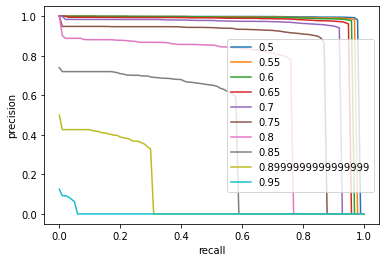

In [32]:
for iou_ind, iou in enumerate(params.iouThrs):
    plt.plot(params.recThrs, precision[iou_ind, :, 0, 0, 2], label=iou)
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')

In [168]:
input['image_id']

1

In [69]:
cocoEval.params.imgIds

[7]

In [107]:
#precision has dims (iou, recall, cls, area range, max dets)
precision = coco_result['bbox']['precision']
params = coco_result['bbox']['recall']

print(params.iouThrs)
print(params.recThrs)
print(params.catIds)
print(params.areaRng)
print(params.maxDets)

KeyError: 'recall'

In [99]:
precision[3, :, 0, 0, 2]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[1, 2, 3, 4, 5]
[[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
[1, 10, 100]


In [77]:
precision[:, 0, :, 0, 0]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
print(batch[ind]["instances"])
print(outputs[ind]["instances"])

In [90]:
meta = MetadataCatalog.get("train")

reverse_id_mapping = {
                v: k for k, v in meta.thing_dataset_id_to_contiguous_id.items()
            }

reverse_id_mapping

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

batch_num: 0
[{'instances': Instances(num_instances=27, image_height=1080, image_width=2048, fields=[pred_boxes: Boxes(tensor([[1304.9272,  524.8882, 1341.0674,  550.8210],
        [ 979.5905,  478.3118, 1010.7137,  506.8691],
        [1441.3162,  442.7038, 1461.2266,  476.2024],
        [1801.6318,  365.9084, 1835.6147,  390.8714],
        [ 611.0220,  477.8048,  647.6956,  496.3259],
        [1750.8489,  128.6282, 1778.1055,  164.2704],
        [1350.1113,  563.5861, 1383.7341,  584.9239],
        [ 922.2675,  377.9962,  953.9513,  404.1373],
        [1528.1283,  486.2837, 1561.9086,  507.1840],
        [1399.6396,  577.1100, 1434.9370,  602.3642],
        [ 612.2607,  408.3645,  651.7135,  430.9018],
        [ 997.3646,  330.4041, 1013.8353,  364.4885],
        [ 382.9980,  429.8458,  419.0331,  450.9895],
        [1768.4812,  296.0073, 1789.8103,  332.2287],
        [1452.8000,  438.2319, 1487.8350,  458.8658],
        [ 952.7478,  402.7686,  989.0928,  419.4193],
        [1795.380

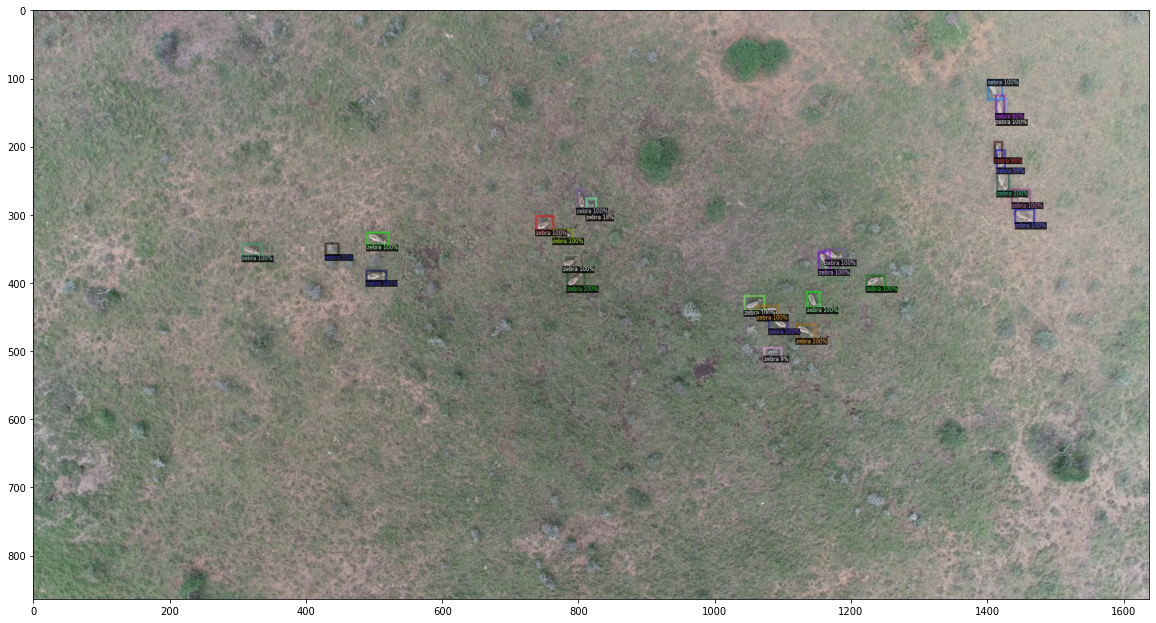

In [32]:
import time
# Check training

show_ims = True

cfg.DATASETS.TEST = ("val", )
# predictor = DefaultPredictor(cfg)

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

pred_dicts = val_dicts
num_frames = len(pred_dicts)
# num_frames = 10
t = time.time()
with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        if show_ims:
            if batch_num >= 1:
                break
        if batch_num % 50 == 0:
            print(f"batch_num: {batch_num}")
    # for d in train_dicts:
    #     im = cv2.imread(d["file_name"])
        outputs = model(batch)
        print(outputs)
        if not show_ims:
            evaluator.process(batch, outputs)
        else:
            for output in outputs:
                im = (
                    np.transpose(batch[0]['image'].numpy(), (1, 2, 0))
                ).astype(int)
                v = Visualizer(im[:, :, ::],
                               metadata=train_metadata,
                               scale=0.8,

                )
                v = v.draw_instance_predictions(output["instances"].to("cpu"))
                plt.figure(figsize=(20,20))
                plt.imshow(v.get_image()[:, :, ::-1])
total_time = time.time() - t
print(f"fps: {num_frames/total_time}, total_time {total_time}, num_frames {num_frames}")
if not show_ims:
    evaluator.evaluate()

In [31]:
print(outputs)


[{'instances': Instances(num_instances=2, image_height=1080, image_width=2048, fields=[pred_boxes: Boxes(tensor([[   0.0000,  885.3605, 2048.0000,  929.8320],
        [   0.0000,  576.8205, 2048.0000,  605.5154]], device='cuda:0')), scores: tensor([1., 1.], device='cuda:0'), pred_classes: tensor([3, 3], device='cuda:0')])}]


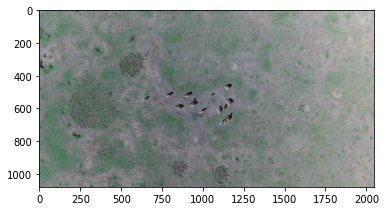

In [20]:
plt.imshow((np.transpose(batch[0]['image'].numpy(), (1, 2, 0))).astype(int))

In [16]:
outputs[0]['im'.requires_grad()

AttributeError: 'list' object has no attribute 'requires_grad'

In [19]:
outputs[0]

{'instances': Instances(num_instances=1, image_height=1080, image_width=2048, fields=[pred_boxes: Boxes(tensor([[   0.,    0., 2048., 1080.]], device='cuda:0',
        grad_fn=<IndexBackward>)), scores: tensor([1.], device='cuda:0', grad_fn=<IndexBackward>), pred_classes: tensor([4], device='cuda:0')])}